<a href="https://colab.research.google.com/github/nandhureji1731/springboardmentor5959e/blob/main/oil_spill_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WEEK 1-2

In [1]:
!pip install --quiet streamlit flask pyngrok tensorflow pillow opencv-python streamlit-lottie requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 74.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
PROJECT_DIR = "/content/drive/MyDrive/Oil_Spill_Detection"
os.makedirs(PROJECT_DIR, exist_ok=True)
print("✅ Project folder ready at:", PROJECT_DIR)


Mounted at /content/drive
✅ Project folder ready at: /content/drive/MyDrive/Oil_Spill_Detection


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Path where dataset is stored inside Drive
BASE_PATH = "/content/drive/MyDrive/dataset/"
TRAIN_IMG_DIR = BASE_PATH + "train/images/"
TRAIN_MASK_DIR = BASE_PATH + "train/masks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split

In [6]:
def load_data(img_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []


    if not os.path.exists(img_dir):
        print(f"Error: Image directory not found: {img_dir}")
        return None, None
    if not os.path.exists(mask_dir):
        print(f"Error: Mask directory not found: {mask_dir}")
        return None, None

    print(f"Contents of image directory {img_dir}: {os.listdir(img_dir)[:10]}...") # Print first 10 files
    print(f"Contents of mask directory {mask_dir}: {os.listdir(mask_dir)[:10]}...") # Print first 10 files


    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    if len(img_files) != len(mask_files):
        print(f"Warning: Number of image files ({len(img_files)}) does not match number of mask files ({len(mask_files)}).")


    for img_name, mask_name in zip(img_files, mask_files):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)


        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image file: {img_path}. Skipping.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Could not load mask file: {mask_path}. Skipping.")
            continue
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0

        images.append(img)
        masks.append(mask.reshape(img_size[0], img_size[1], 1))

    return np.array(images), np.array(masks)

X, Y = load_data(TRAIN_IMG_DIR, TRAIN_MASK_DIR)

if X is not None and Y is not None:
    print("Images shape:", X.shape)
    print("Masks shape:", Y.shape)

Contents of image directory /content/drive/MyDrive/dataset/train/images/: ['Oil (225).jpg', 'Oil (652).jpg', 'Oil (72).jpg', 'Oil (1157).jpg', 'Oil (122).jpg', 'Oil (107).jpg', 'Oil (450).jpg', 'Oil (1054).jpg', 'Oil (297).jpg', 'Oil (523).jpg']...
Contents of mask directory /content/drive/MyDrive/dataset/train/masks/: ['Oil (503).png', 'Oil (676).png', 'Oil (551).png', 'Oil (652).png', 'Oil (989).png', 'Oil (481).png', 'Oil (163).png', 'Oil (73).png', 'Oil (1054).png', 'Oil (830).png']...
Images shape: (811, 256, 256, 3)
Masks shape: (811, 256, 256, 1)


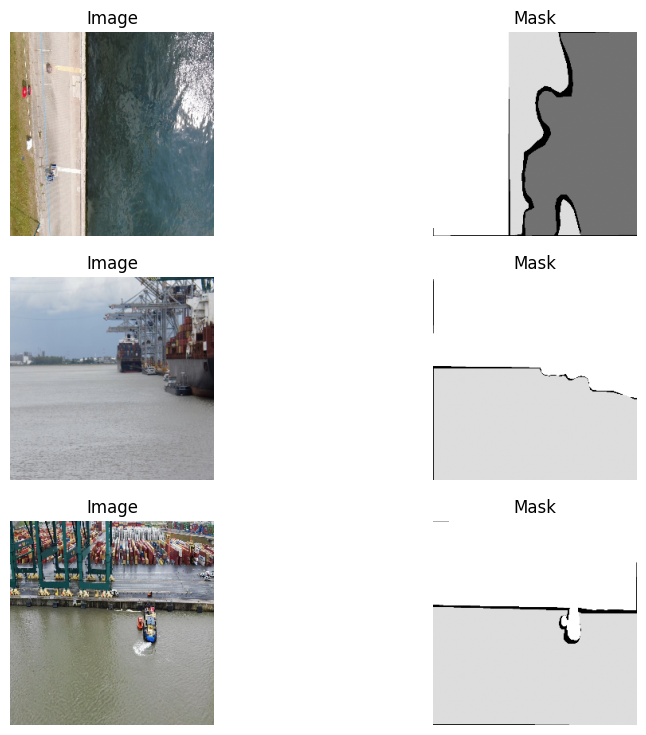

In [7]:
def visualize_samples(X, Y, num_samples=3):
    if X is None or Y is None:
        print("Cannot visualize samples: Data not loaded properly.")
        return

    plt.figure(figsize=(10, num_samples * 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(X[idx])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(Y[idx].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.show()

visualize_samples(X, Y)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)


Training set: (648, 256, 256, 3) (648, 256, 256, 1)
Validation set: (163, 256, 256, 3) (163, 256, 256, 1)


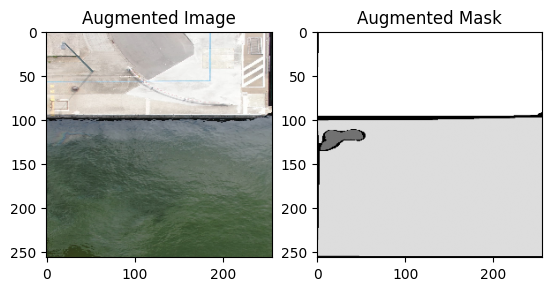

In [9]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

def augment_data(image, mask):
    augmented = augment(image=(image*255).astype(np.uint8), mask=(mask*255).astype(np.uint8))
    return augmented['image']/255.0, augmented['mask']/255.0

#Eg
aug_img, aug_mask = augment_data(X[0], Y[0])

plt.subplot(1,2,1)
plt.imshow(aug_img)
plt.title("Augmented Image")

plt.subplot(1,2,2)
plt.imshow(aug_mask, cmap="gray")
plt.title("Augmented Mask")
plt.show()


WEEK 3-4

import


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


 model

In [11]:

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    us = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding="same")(x)
    concat = layers.Concatenate()([us, skip])
    c = conv_block(concat, filters)
    return c

def build_unet(input_shape=(128,128,3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)

    # Bottleneck
    bn = conv_block(p3, 256)

    # Decoder
    d1 = decoder_block(bn, c3, 128)
    d2 = decoder_block(d1, c2, 64)
    d3 = decoder_block(d2, c1, 32)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(d3)

    model = models.Model(inputs, outputs)
    return model

# Build model
model = build_unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", dice_coef])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

resize for faster execution

In [12]:
IMG_SIZE = (128,128)  # faster than 256x256

X_small, Y_small = load_data(TRAIN_IMG_DIR, TRAIN_MASK_DIR, img_size=IMG_SIZE)

X_train, X_val, Y_train, Y_val = train_test_split(X_small, Y_small, test_size=0.2, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape)


Contents of image directory /content/drive/MyDrive/dataset/train/images/: ['Oil (225).jpg', 'Oil (652).jpg', 'Oil (72).jpg', 'Oil (1157).jpg', 'Oil (122).jpg', 'Oil (107).jpg', 'Oil (450).jpg', 'Oil (1054).jpg', 'Oil (297).jpg', 'Oil (523).jpg']...
Contents of mask directory /content/drive/MyDrive/dataset/train/masks/: ['Oil (503).png', 'Oil (676).png', 'Oil (551).png', 'Oil (652).png', 'Oil (989).png', 'Oil (481).png', 'Oil (163).png', 'Oil (73).png', 'Oil (1054).png', 'Oil (830).png']...
Train: (648, 128, 128, 3) Val: (163, 128, 128, 3)


metrics and compile model

In [13]:
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=[ "accuracy",dice_coef])


Train

In [14]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=25,
    verbose=1
)


Epoch 1/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.0028 - dice_coef: 0.5985 - loss: 0.6676 - val_accuracy: 0.0315 - val_dice_coef: 0.6011 - val_loss: 0.6429
Epoch 2/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0152 - dice_coef: 0.6215 - loss: 0.6389 - val_accuracy: 0.0349 - val_dice_coef: 0.6288 - val_loss: 0.6344
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0224 - dice_coef: 0.6214 - loss: 0.6333 - val_accuracy: 0.0182 - val_dice_coef: 0.6543 - val_loss: 0.6530
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0196 - dice_coef: 0.6276 - loss: 0.6313 - val_accuracy: 0.0280 - val_dice_coef: 0.6470 - val_loss: 0.6281
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0201 - dice_coef: 0.6297 - loss: 0.6283 - val_accuracy: 0.0397 - val_dice_coef: 0.6412 - val_loss: 0.6172
Epoch 6/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0216 - dice_coef: 0.6348 - loss: 0.6181 - val_accuracy: 0.0333 - val_dice_coef:

Visual

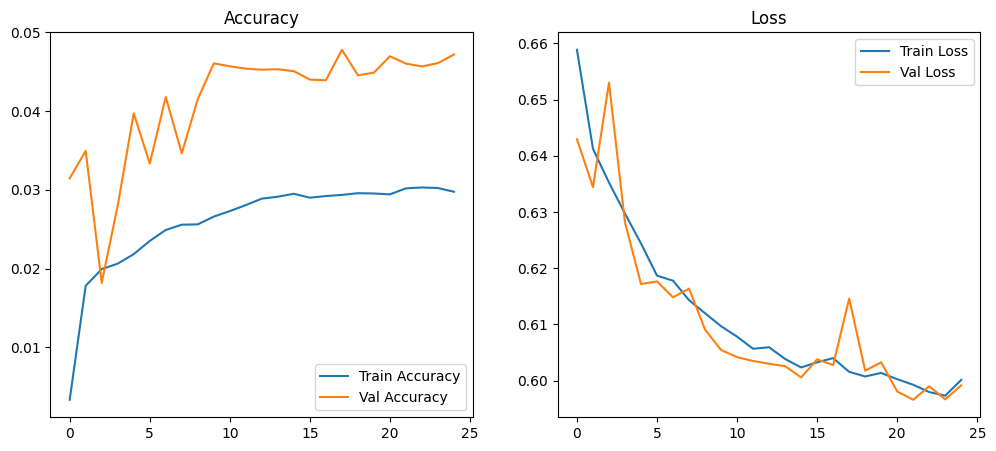

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
if 'accuracy' in history.history:
  plt.plot(history.history["accuracy"], label="Train Accuracy")
if 'val_accuracy' in history.history:
  plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


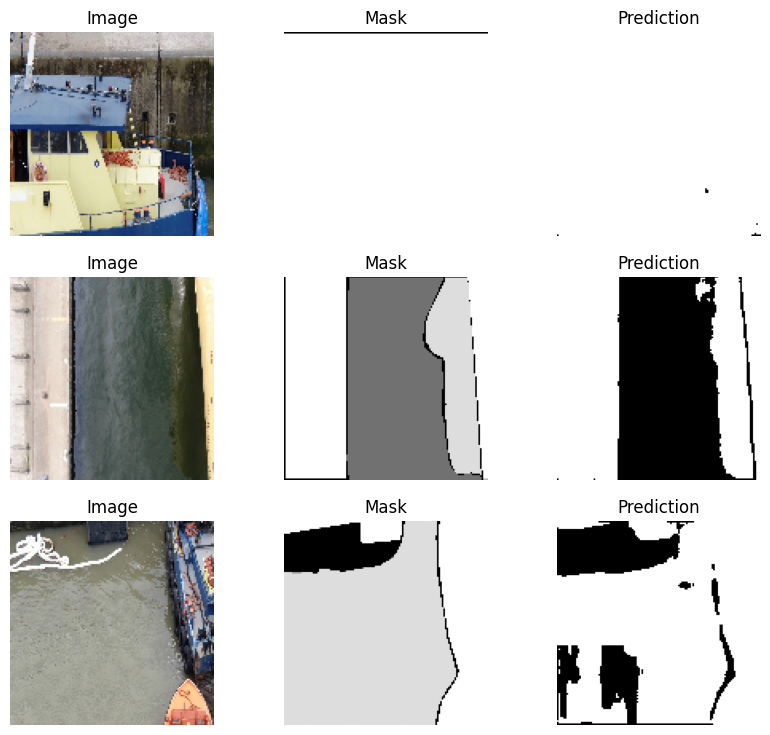

In [16]:
def show_predictions(model, X, Y, num=3):
    preds = model.predict(X[:num])
    plt.figure(figsize=(10, num*3))
    for i in range(num):
        plt.subplot(num,3,3*i+1)
        plt.imshow(X[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num,3,3*i+2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(num,3,3*i+3)
        plt.imshow((preds[i].squeeze() > 0.5), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

show_predictions(model, X_val, Y_val, num=3)


week 5-6


In [17]:
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def precision_metric(y_true, y_pred):
    y_pred_f = K.round(K.flatten(y_pred))
    y_true_f = K.flatten(y_true)
    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    return tp / (tp + fp + K.epsilon())

def recall_metric(y_true, y_pred):
    y_pred_f = K.round(K.flatten(y_pred))
    y_true_f = K.flatten(y_true)
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + fn + K.epsilon())

# Recompile model with full metrics
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", dice_coef, iou_metric, precision_metric, recall_metric])

evaluation on valid set

In [18]:
results = model.evaluate(X_val, Y_val, verbose=1)
print("Validation Results:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.0603 - dice_coef: 0.6450 - iou_metric: 0.4761 - loss: 0.5977 - precision_metric: 0.7326 - recall_metric: 0.7474
Validation Results:
loss: 0.5992
compile_metrics: 0.0472


plot training curves

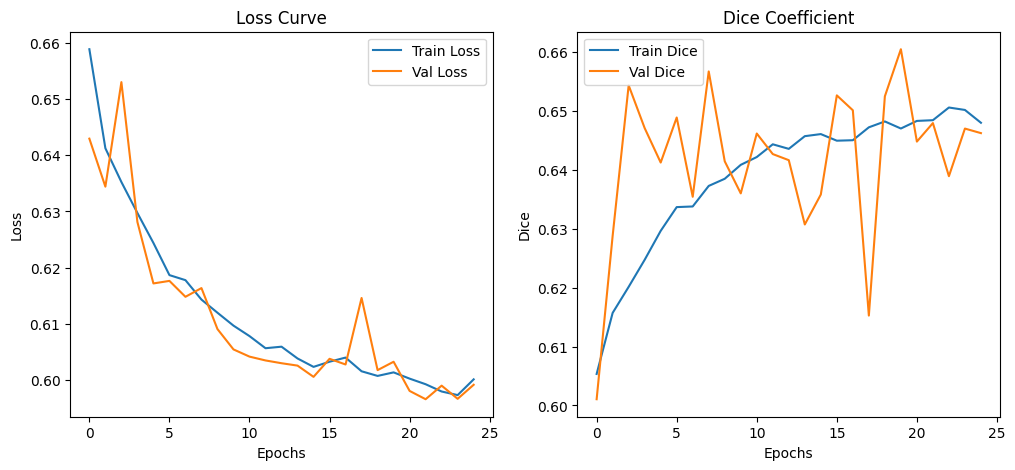

In [19]:
def plot_training(history):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Dice Coefficient
    plt.subplot(1,2,2)
    plt.plot(history.history["dice_coef"], label="Train Dice")
    plt.plot(history.history["val_dice_coef"], label="Val Dice")
    plt.title("Dice Coefficient")
    plt.xlabel("Epochs")
    plt.ylabel("Dice")
    plt.legend()

    plt.show()

plot_training(history)

side by side visualisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


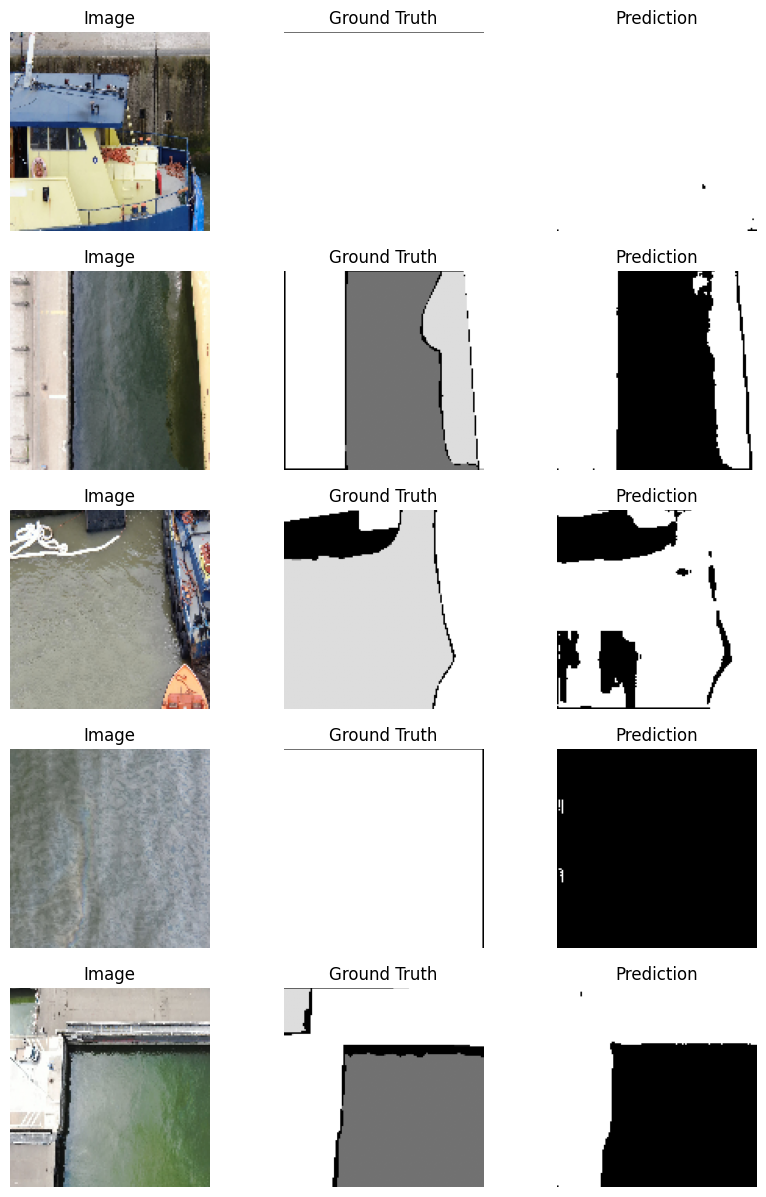

In [20]:
def compare_predictions(model, X, Y, num=3):
    preds = model.predict(X[:num])
    plt.figure(figsize=(10, num*3))
    for i in range(num):
        plt.subplot(num,3,3*i+1)
        plt.imshow(X[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num,3,3*i+2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num,3,3*i+3)
        plt.imshow((preds[i].squeeze() > 0.5), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

compare_predictions(model, X_val, Y_val, num=5)

week 7-8


In [21]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/Oil_Spill_Detection/oil_spill_unet.h5" ./oil_spill_unet.h5


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip install pyngrok

In [24]:
!pip install streamlit

In [102]:
from pyngrok import ngrok
# Set the auth token
ngrok.conf.get_default().auth_token = "33QYdWt6Mb7yKPlc8cRs6QTJHk2_7Gz7L9Uw6WGT6TU5wGakq"
print("✅ Auth token set successfully.")

✅ Auth token set successfully.


flask backend

In [84]:
!mkdir -p backend
!mkdir -p results


In [105]:
%%writefile backend/app.py
import io, os, base64
import numpy as np
from PIL import Image, ImageOps
from flask import Flask, request, jsonify
import tensorflow as tf

MODEL_PATH = "/content/drive/MyDrive/Oil_Spill_Detection/oil_spill_unet.h5"  # update if needed

app = Flask(__name__)

# Load model once
if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    print("✅ Model Loaded Successfully!")
else:
    print("❌ Model NOT found at:", MODEL_PATH)
    model = None

def preprocess(img, size):
    img = img.convert("RGB")
    img = ImageOps.fit(img, size)
    arr = np.array(img) / 255.0
    return np.expand_dims(arr.astype(np.float32), axis=0)

def postprocess(mask, orig_size):
    mask = mask.squeeze()
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    m = (mask * 255).astype(np.uint8)
    return Image.fromarray(m).resize(orig_size)

@app.route("/predict", methods=["POST"])
def predict():
    if model is None:
        return jsonify({"error":"Model not loaded"}), 500

    if "image" not in request.files:
        return jsonify({"error":"No image uploaded"}), 400

    file = request.files["image"]
    img = Image.open(io.BytesIO(file.read()))
    orig_size = (img.width, img.height)

    # Input size from model
    h, w = model.input_shape[1], model.input_shape[2]
    x = preprocess(img, (w, h))

    pred = model.predict(x)[0]
    mask_img = postprocess(pred, orig_size)

    # Binary mask for area %
    mask_bin = mask_img.point(lambda p: 255 if p >= 127 else 0)
    mask_np = np.array(mask_bin.convert("L"))
    area_pct = 100 * (np.count_nonzero(mask_np) / mask_np.size)

    # Send mask as base64
    buf = io.BytesIO()
    mask_bin.save(buf, format="PNG")
    mask_b64 = base64.b64encode(buf.getvalue()).decode()

    return jsonify({
        "mask_base64": mask_b64,
        "area_percent": round(float(area_pct), 4)
    })

@app.route("/")
def home():
    return "✅ Flask Backend is Running"

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)


Overwriting backend/app.py


streamlet

In [103]:
%%writefile frontend/user_auth.py
import sqlite3

DB = "users.db"

def create_user_table():
    conn = sqlite3.connect(DB)
    c = conn.cursor()
    c.execute("""
        CREATE TABLE IF NOT EXISTS users(
            username TEXT PRIMARY KEY,
            password TEXT,
            email TEXT
        )
    """)
    conn.commit()
    conn.close()

def add_user(username, password, email=""):
    conn = sqlite3.connect(DB)
    c = conn.cursor()
    try:
        c.execute("INSERT INTO users(username,password,email) VALUES(?,?,?)",
                  (username, password, email))
        conn.commit()
        ok = True
    except:
        ok = False
    conn.close()
    return ok

def authenticate(username, password):
    conn = sqlite3.connect(DB)
    c = conn.cursor()
    c.execute("SELECT 1 FROM users WHERE username=? AND password=?", (username, password))
    row = c.fetchone()
    conn.close()
    return bool(row)

def fetch_email(username):
    conn = sqlite3.connect(DB)
    c = conn.cursor()
    c.execute("SELECT email FROM users WHERE username=?", (username,))
    row = c.fetchone()
    conn.close()
    return row[0] if row else ""


Overwriting frontend/user_auth.py


Authintecation DB

In [106]:
from frontend.user_auth import create_user_table
create_user_table()
print("✅ users.db ready")


✅ users.db ready


In [107]:
from frontend.user_auth import create_user_table
create_user_table()
print("✅ Auth system ready")


✅ Auth system ready


Frontend


In [145]:
%%writefile app_frontend.py
import os
import io
import time
import json
import base64
import shutil
import datetime
from pathlib import Path

import numpy as np
from PIL import Image
import streamlit as st
import requests


try:
    from streamlit_lottie import st_lottie
    HAS_LOTTIE = True
except Exception:
    HAS_LOTTIE = False

try:
    from reportlab.pdfgen import canvas
    from reportlab.lib.pagesizes import A4
    HAS_REPORTLAB = True
except Exception:
    HAS_REPORTLAB = False

try:
    import yagmail
    HAS_YAGMAIL = True
except Exception:
    HAS_YAGMAIL = False


AUTH_OK = True
try:
    from frontend.user_auth import create_user_table, authenticate
except Exception:
    AUTH_OK = False



st.set_page_config(
    page_title="AI SpillGuard — Oil Spill Detection",
    page_icon="🛟",
    layout="wide",
    initial_sidebar_state="expanded",
)


RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

SAVED_DIR = Path("saved_results")
SAVED_DIR.mkdir(parents=True, exist_ok=True)

REPORTS_DIR = Path("reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Admin credentials
ADMIN_USER = "admin"
ADMIN_PASS = "oilspill2025"



mode = st.sidebar.radio("🌗 Theme", ["Dark", "Light"], index=0)
if mode == "Dark":
    st.markdown("""
    <style>
    body {
        background: url('https://images.unsplash.com/photo-1507525428034-b723cf961d3e') no-repeat center center fixed;
        background-size: cover;
        color: #ffffff !important;
    }
    .sidebar .sidebar-content { background: rgba(6, 21, 33, 0.85) !important; }
    img { border-radius: 12px; }
    .fade-in { animation: fadein 0.9s ease-in-out; }
    @keyframes fadein { from {opacity: 0;} to {opacity: 1;} }
    </style>
    """, unsafe_allow_html=True)
else:
    st.markdown("""
    <style>
    body {
        background: url('https://images.unsplash.com/photo-1507525428034-b723cf961d3e') no-repeat center center fixed;
        background-size: cover;
        color: #111 !important;
    }
    .sidebar .sidebar-content { background: rgba(240, 248, 255, 0.85) !important; }
    img { border-radius: 12px; }
    .fade-in { animation: fadein 0.9s ease-in-out; }
    @keyframes fadein { from {opacity: 0;} to {opacity: 1;} }
    </style>
    """, unsafe_allow_html=True)



st.sidebar.title("⚙️ Controls")
BACKEND_URL = st.sidebar.text_input("🔗 Flask Backend URL", "http://127.0.0.1:5000")

if st.sidebar.button("🚪 Logout"):
    st.session_state.clear()
    st.rerun()

st.sidebar.caption("👨‍💻 Developed by **Nandhu Reji**")
st.sidebar.markdown("---")



# IMAGE + MODEL UTILS

def load_lottie(url: str):
    if not HAS_LOTTIE:
        return None
    try:
        r = requests.get(url, timeout=10)
        if r.status_code == 200:
            return r.json()
    except:
        return None
    return None


def request_prediction(image_bytes: bytes):
    try:
        res = requests.post(
            f"{BACKEND_URL}/predict",
            files={"image": image_bytes},
            timeout=120
        )
    except Exception as e:
        return None, None, f"❌ Could not connect to backend: {e}"

    if res.status_code != 200:
        return None, None, f"❌ Backend Error: {res.status_code} — {res.text}"

    data = res.json()
    if "mask_base64" not in data or "area_percent" not in data:
        return None, None, "❌ Invalid backend response."
    return data["mask_base64"], data["area_percent"], None


def decode_mask(mask_b64: str) -> Image.Image:
    mask_bytes = base64.b64decode(mask_b64)
    return Image.open(io.BytesIO(mask_bytes)).convert("L")


def overlay_mask(image: Image.Image, mask_img: Image.Image, alpha: float, threshold: int) -> Image.Image:
    img = image.convert("RGBA")
    w, h = img.size
    mask_np = np.asarray(mask_img)

    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    rgba[..., 0] = mask_np
    rgba[..., 3] = (mask_np > threshold) * int(alpha * 255)

    overlay = Image.fromarray(rgba, "RGBA")
    return Image.alpha_composite(img, overlay).convert("RGB")


def save_images(original: Image.Image, mask_img: Image.Image, overlay_img: Image.Image):
    ts = time.strftime("%Y%m%d-%H%M%S")
    orig_p = RESULTS_DIR / f"spill_{ts}_orig.png"
    mask_p = RESULTS_DIR / f"spill_{ts}_mask.png"
    over_p = RESULTS_DIR / f"spill_{ts}_overlay.png"

    original.save(orig_p)
    mask_img.save(mask_p)
    overlay_img.save(over_p)

    return str(orig_p), str(mask_p), str(over_p)


def save_history(username: str, area: float, orig_path: str, mask_path: str, overlay_path: str):
    hist_file = SAVED_DIR / "history.json"
    if hist_file.exists():
        try:
            hist = json.load(open(hist_file, "r"))
        except:
            hist = []
    else:
        hist = []

    hist.append({
        "username": username or "guest",
        "timestamp": str(datetime.datetime.now()),
        "area": float(area),
        "original": orig_path,
        "mask": mask_path,
        "overlay": overlay_path,
    })

    json.dump(hist, open(hist_file, "w"), indent=2)


def autosave_to_drive(paths):
    drive_root = Path("/content/drive/MyDrive/AI_SpillGuard")
    try:
        if drive_root.exists():
            drive_root.mkdir(parents=True, exist_ok=True)
            for p in paths:
                shutil.copy(p, drive_root / Path(p).name)
            return True, str(drive_root)
    except:
        pass
    return False, None


def generate_pdf(area: float, orig_path: str, mask_path: str, overlay_path: str):
    if not HAS_REPORTLAB:
        return None

    pdf_path = REPORTS_DIR / f"report_{int(time.time())}.pdf"
    c = canvas.Canvas(str(pdf_path), pagesize=A4)
    w, h = A4

    c.setFont("Helvetica-Bold", 20)
    c.drawString(150, h - 40, "AI SpillGuard — Detection Report")

    c.setFont("Helvetica", 12)
    c.drawString(50, h - 70, f"Generated: {time.ctime()}")
    c.drawString(50, h - 85, f"Estimated Spill Area: {area}%")

    try:
        c.drawImage(orig_path, 40, h - 380, width=160, height=160, preserveAspectRatio=True, mask='auto')
        c.drawImage(mask_path, 220, h - 380, width=160, height=160, preserveAspectRatio=True, mask='auto')
        c.drawImage(overlay_path, 400, h - 380, width=160, height=160, preserveAspectRatio=True, mask='auto')
    except:
        pass

    c.setFont("Helvetica", 10)
    c.drawString(50, 40, "© 2025 AI SpillGuard | Developed by Nandhu Reji")
    c.showPage()
    c.save()
    return str(pdf_path)


def send_email_report(to_email: str, pdf_file: str):
    if not HAS_YAGMAIL:
        return False, "yagmail not installed."
    if not to_email:
        return False, "No recipient email provided."

    GMAIL = os.getenv("SPILLGUARD_GMAIL")
    APP_PASS = os.getenv("SPILLGUARD_APP_PASSWORD")

    if not GMAIL or not APP_PASS:
        return False, "Email environment variables missing."

    try:
        yag = yagmail.SMTP(GMAIL, APP_PASS)
        yag.send(
            to=to_email,
            subject="AI SpillGuard — Detection Report",
            contents="Attached is your oil spill detection report.",
            attachments=[pdf_file]
        )
        return True, "Sent."
    except Exception as e:
        return False, f"Failed: {e}"



if AUTH_OK:
    try:
        create_user_table()
    except:
        pass



def login_page():
    st.markdown("<h1 class='fade-in'>🛟 AI SpillGuard Login</h1>", unsafe_allow_html=True)

    username = st.text_input("Username")
    password = st.text_input("Password", type="password")

    if st.button("✅ Login"):
        if username == ADMIN_USER and password == ADMIN_PASS:
            st.session_state["logged_in"] = True
            st.session_state["role"] = "admin"
            st.session_state["username"] = ADMIN_USER
            st.success("✅ Admin Login Successful")
            st.rerun()
        elif AUTH_OK and authenticate(username, password):
            st.session_state["logged_in"] = True
            st.session_state["role"] = "user"
            st.session_state["username"] = username
            st.success("✅ Login Successful")
            st.rerun()
        else:
            st.error("❌ Invalid username or password")



def home_page():
    st.markdown("""
    <h1 class="fade-in" style="text-align:center; font-size:48px; color:white; text-shadow:2px 2px 10px black;">
        Protect Our Oceans with AI
    </h1>
    """, unsafe_allow_html=True)

    st.markdown("""
    <h3 style="text-align:center; color:white; max-width:900px; margin:auto;">
        Oil spills devastate marine life and coastal ecosystems. Our intelligent oil spill detection system
        uses satellite data and AI to identify spills instantly—helping authorities act faster and prevent irreversible damage.
    </h3>
    """, unsafe_allow_html=True)

    st.write("")
    st.write("")

    if HAS_LOTTIE:
        anim = load_lottie("https://assets6.lottiefiles.com/packages/lf20_49rdyysj.json")
        if anim:
            st_lottie(anim, height=300)

    st.markdown("""
    <div style='background: rgba(0, 0, 0, 0.55); padding:25px; border-radius:12px; color:white'>
    <h2>🌍 Why Oil Spill Detection Matters</h2>

    Oil spills are among the most dangerous marine disasters, causing long-term harm to aquatic habitats,
    coastal economies, and global ecosystems. Traditional detection methods—such as manual patrols or limited
    satellite monitoring—often delay response efforts.

    <br><br>
    ✅ Our system leverages advanced image processing and deep learning to detect spills accurately in near real-time.
    ✅ Enables rapid spill identification, reducing environmental impact
    ✅ Supports sustainability by protecting biodiversity and natural resources
    ✅ Offers data-driven insights for environmental agencies and researchers
    ✅ Enhances early-warning capabilities to reduce cleanup time and costs

    <br>
    Together, these innovations make oil spill monitoring faster, smarter, and more reliable—paving the way
    for a cleaner and safer ocean environment.
    </div>
    """, unsafe_allow_html=True)



def detect_page():
    st.header("📤 Upload Image for Detection")

    uploaded = st.file_uploader("Select image",
                                type=["png", "jpg", "jpeg", "tif", "tiff"])
    alpha = st.slider("🎨 Overlay transparency", 0.05, 1.0, 0.45)
    thr = st.slider("🎯 Mask threshold", 0, 255, 127)

    if uploaded:
        original = Image.open(uploaded)
        st.image(original, caption="Uploaded", use_column_width=True)

        if st.button("🔍 Run Detection"):
            with st.spinner("⏳ Contacting backend..."):
                mask_b64, area_pct, err = request_prediction(uploaded.getvalue())

            if err:
                st.error(err)
                return

            mask_img = decode_mask(mask_b64)
            overlay = overlay_mask(original, mask_img, alpha, thr)

            st.success("✅ Detection complete!")

            c1, c2, c3 = st.columns(3)
            c1.subheader("📷 Original")
            c1.image(original, use_column_width=True)

            c2.subheader("🎭 Predicted Mask")
            c2.image(mask_img, use_column_width=True)

            c3.subheader("🔴 Overlay")
            c3.image(overlay, use_column_width=True)

            orig_p, mask_p, overlay_p = save_images(original, mask_img, overlay)
            save_history(st.session_state.get("username", "guest"),
                         area_pct, orig_p, mask_p, overlay_p)

            drive_ok, drive_path = autosave_to_drive([orig_p, mask_p, overlay_p])
            if drive_ok:
                st.info(f"💾 Auto-saved to Google Drive: {drive_path}")

            st.subheader("💾 Download Results")
            col1, col2, col3 = st.columns(3)
            col1.download_button("Overlay",
                                 data=open(overlay_p, "rb").read(),
                                 file_name="overlay.png",
                                 mime="image/png")
            col2.download_button("Mask",
                                 data=open(mask_p, "rb").read(),
                                 file_name="mask.png",
                                 mime="image/png")
            col3.download_button("Original",
                                 data=open(orig_p, "rb").read(),
                                 file_name="original.png",
                                 mime="image/png")

            st.metric("🛢 Estimated Spill Area (%)", f"{area_pct}%")

            pdf_path = None
            if HAS_REPORTLAB:
                pdf_path = generate_pdf(area_pct, orig_p, mask_p, overlay_p)
                if pdf_path:
                    st.download_button("📄 Download PDF Report",
                                       data=open(pdf_path, "rb").read(),
                                       file_name="AI_SpillGuard_Report.pdf",
                                       mime="application/pdf")
            else:
                st.info("Install reportlab for PDF support.")

            st.markdown("---")
            email = st.text_input("📧 Send report to email")
            if st.button("✉ Send Report via Email"):
                if not pdf_path:
                    st.error("Generate PDF first.")
                else:
                    ok, msg = send_email_report(email, pdf_path)
                    if ok:
                        st.success(f"✅ Report sent to {email}")
                    else:
                        st.error(msg)


def history_page():
    st.header("📁 Detection History")
    hist_file = SAVED_DIR / "history.json"
    if not hist_file.exists():
        st.info("No history yet.")
        return

    try:
        hist = json.load(open(hist_file, "r"))
    except:
        st.error("History file corrupt.")
        return

    role = st.session_state.get("role", "user")
    user = st.session_state.get("username", "guest")
    if role != "admin":
        hist = [h for h in hist if h.get("username") == user]

    if not hist:
        st.info("No records.")
        return

    for item in reversed(hist[-50:]):
        st.markdown("---")
        st.write(f"🕒 {item.get('timestamp')}")
        st.write(f"👤 User: {item.get('username')}")
        st.write(f"🛢 Spill Area: **{item.get('area')}%**")

        c1, c2, c3 = st.columns(3)
        try:
            c1.image(item.get("original"), caption="Original", use_column_width=True)
            c2.image(item.get("mask"), caption="Mask", use_column_width=True)
            c3.image(item.get("overlay"), caption="Overlay", use_column_width=True)
        except:
            pass


def about_page():
    st.header("ℹ️ About AI SpillGuard")
    st.markdown("""
    **AI SpillGuard** is an AI-powered platform designed to automatically detect oil spills from satellite or aerial imagery. Using deep learning and image processing techniques, the system analyzes visual data to identify potential oil-contaminated regions on the ocean surface with high precision.

The project integrates Convolutional Neural Networks (CNNs) and advanced preprocessing algorithms to distinguish between oil spills and other look-alike features such as clouds, algae, or shadows. Once a spill is detected, the system can visualize the results and generate alerts for immediate response.

🎯 Key Objectives

To detect and monitor oil spills accurately and efficiently.

To assist environmental agencies in minimizing marine pollution impacts.

To reduce response time through automated, real-time detection.

To support sustainability and ocean protection through technology-driven innovation.

⚙️ How It Works

Input Image Upload: Users can upload satellite or drone-captured images of sea surfaces.

Preprocessing: The image is enhanced and cleaned to remove noise and irrelevant data.

Model Prediction: A trained deep learning model identifies and classifies regions containing oil spills.

Visualization: Detected spill areas are highlighted and displayed for easy interpretation.

This system demonstrates the power of Artificial Intelligence in addressing critical environmental challenges, offering an efficient and scalable solution for monitoring ocean health.
    """)


def footer():
    st.markdown("""
    <hr />
    <p style='text-align:center; color:white; text-shadow:1px 1px 3px black;'>
      © 2025 AI SpillGuard • Developed by <b>Nandhu Reji</b>
    </p>
    """, unsafe_allow_html=True)



# =====================================================
# ROUTER
# =====================================================
if "logged_in" not in st.session_state:
    st.session_state["logged_in"] = False

if not st.session_state["logged_in"]:
    login_page()
else:
    menu = st.sidebar.radio("📌 Navigation",
                            ["🏠 Home", "📤 Detect", "📁 History", "ℹ️ About"])
    if menu == "🏠 Home":
        home_page()
    elif menu == "📤 Detect":
        detect_page()
    elif menu == "📁 History":
        history_page()
    elif menu == "ℹ️ About":
        about_page()

    footer()


Overwriting app_frontend.py


History

In [98]:
import json, datetime

def save_history(username, area, orig_path, mask_path, overlay_path):
    history_file = "saved_results/history.json"

    if not os.path.exists("saved_results"):
        os.makedirs("saved_results")

    # Load existing history
    if os.path.exists(history_file):
        hist = json.load(open(history_file))
    else:
        hist = []

    hist.append({
        "username": username,
        "timestamp": str(datetime.datetime.now()),
        "area": area,
        "original": orig_path,
        "mask": mask_path,
        "overlay": overlay_path
    })

    json.dump(hist, open(history_file, "w"), indent=4)


pdf report

In [109]:
!pip install reportlab


In [110]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

def generate_pdf(area, orig, mask, overlay):
    pdf_path = f"reports/report_{int(time.time())}.pdf"
    c = canvas.Canvas(pdf_path, pagesize=A4)

    c.setFont("Helvetica-Bold", 20)
    c.drawString(150, 800, "AI SpillGuard Report")

    c.setFont("Helvetica", 12)
    c.drawString(50, 770, f"Spill Area: {area}%")
    c.drawString(50, 750, f"Generated: {time.ctime()}")

    c.drawImage(orig, 50, 500, width=200, height=200)
    c.drawImage(mask, 300, 500, width=200, height=200)
    c.drawImage(overlay, 175, 250, width=200, height=200)

    c.showPage()
    c.save()
    return pdf_path


email

In [112]:
import yagmail

def send_email(to_email, pdf_file):
    yag = yagmail.SMTP("yourgmail@gmail.com", "your_app_password")
    yag.send(
        to=to_email,
        subject="AI SpillGuard Report",
        contents="Attached is your oil spill detection report.",
        attachments=[pdf_file]
    )
    return True


intall with file

In [113]:
!pip install yagmail reportlab
import os
os.environ["SPILLGUARD_GMAIL"] = "your_gmail@example.com"
os.environ["SPILLGUARD_APP_PASSWORD"] = "your_gmail_app_password"


In [146]:
from pyngrok import ngrok
import subprocess, time

# kill tunnels
for t in ngrok.get_tunnels():
    ngrok.disconnect(t.public_url)

port = 8501
frontend_proc = subprocess.Popen(["streamlit", "run", "app_frontend.py", "--server.port", str(port), "--server.headless", "true"])
time.sleep(4)

public_frontend = ngrok.connect(port)
print("✅ Streamlit Frontend Running At:", public_frontend)


✅ Streamlit Frontend Running At: NgrokTunnel: "https://flory-hydrazo-nellie.ngrok-free.dev" -> "http://localhost:8501"


In [147]:
!python backend/app.py


2025-11-04 17:12:51.275049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762276371.295790   67737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762276371.302255   67737 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762276371.318699   67737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762276371.318727   67737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762276371.318733   67737 computation_placer.cc:177] computation placer alr